# Homework 2: Introduction to SVMs

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import accuracy_score


# use seaborn plotting defaults
import seaborn as sns; sns.set()

In this homework, you will work with the following dataset

In [2]:
data=np.load('DataSet1.npz') 

X_train=data['arr_0']
Y_train=data['arr_1']
#X_test=data['arr_2']


Let's plot it to have an idea about how it looks:

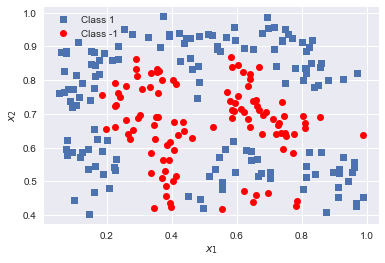

In [3]:
min1=np.min(X_train[:,0])
max1=np.max(X_train[:,0])
min2=np.min(X_train[:,1])
max2=np.max(X_train[:,1])



## Plot Data
index=(Y_train==1).reshape(Y_train.shape[0],)
plt.plot(X_train[index,0],X_train[index,1],'s',label="Class 1")
index=(Y_train==0).reshape(Y_train.shape[0],)
plt.plot(X_train[index,0],X_train[index,1],'ro',label="Class -1")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend()
plt.rcParams["figure.figsize"] = [8,8]

** Question 1 (1 point)** Hold out part of the training data to create a validation. For instance, take the 20% of the data points at random for validation.

In [4]:
from sklearn.model_selection import StratifiedKFold,ShuffleSplit

skf = ShuffleSplit(n_splits=1, test_size=0.2, random_state=None)

for train_index, val_index in skf.split(X_train, Y_train):
      
    X_train_val, X_val = X_train[train_index], X_train[val_index]
    Y_train_val, Y_val = Y_train[train_index], Y_train[val_index]

** Question 2 (4 points)** Train a SVM with a linear kernel. Plot the decision boundary and the $\pm 1$-distance to boundary contour levels. 

Use different values of $C$ and analyze the evolution of the number of support vectors as you vary this quantity. Explain the results!

Compute and plot the classification error rate for both training and validation sets as a function of $C$.

Do you think a linear kernel is adequate in this case?

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)   # k(x1,x2) = x1^T x2
model.fit(X_train_val, np.ravel(Y_train_val))

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above
    
    # From the grid to a list of (x,y) values. 
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating 
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='p')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

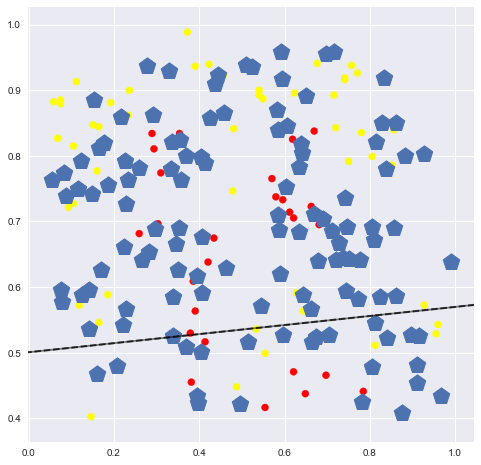

In [7]:
plt.scatter(X_train_val[:, 0], X_train_val[:, 1], c=np.reshape(Y_train_val, [200,]), s=50, cmap='autumn')
plot_svc_decision_function(model)


plt.rcParams["figure.figsize"] = [16,16]

In [8]:
def computeSupportVectors(X, Y, Carray):
    supportVector = np.zeros(len(Carray))
    for index, i in enumerate(Carray):
        model = SVC(kernel='linear', C=i)
        model.fit(X, np.ravel(Y))
        supportVector[index] = len(model.support_vectors_)
    return supportVector

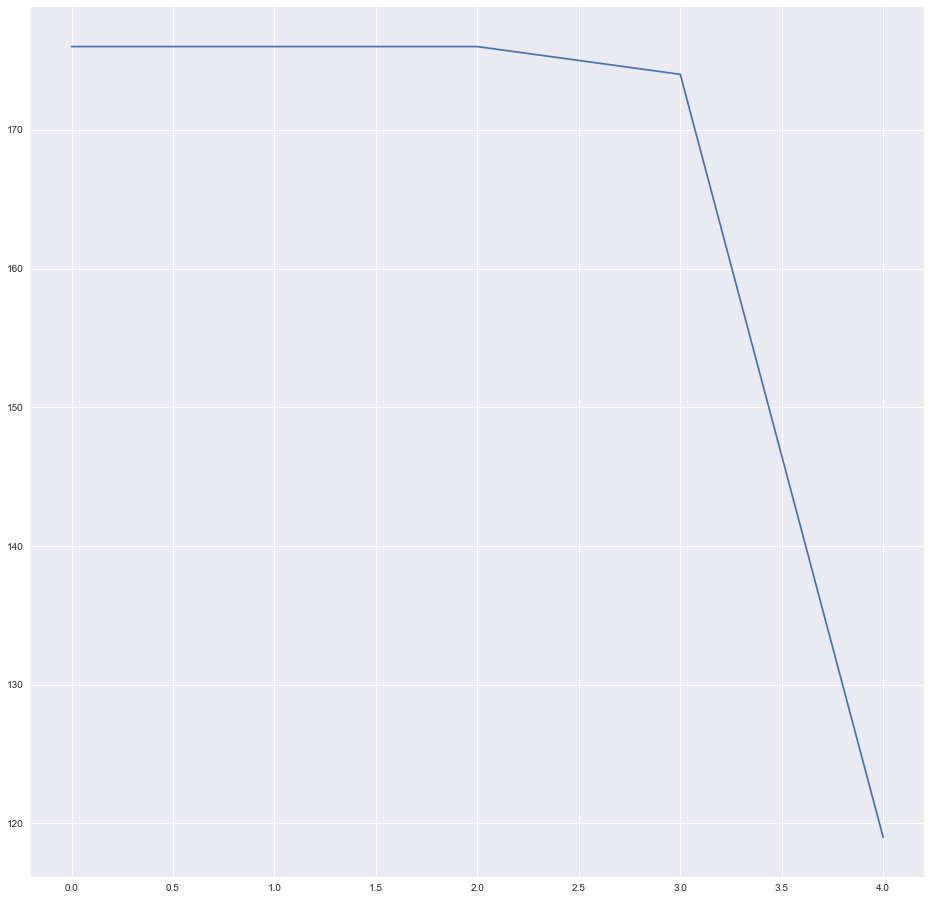

In [9]:
plt.plot(computeSupportVectors(X_train_val,Y_train_val,[10, 100, 1e3, 1e6, 1e10]))

We can appreciatte that since C acts as a weight of the minimization function: The lower the C the least importance this side of the function has therefore, more error would be allowed and more support vector are found; the higher the C the lesser errors are admitted and therefore, less support vectors are created and the grid grows bigger. 

We can appreciatte that with the linear model support vectors created are very high, model doesn't fit well data.

We now compute the error rate for the testing and validations sets:

In [10]:
def meanErrorByC(X, Y, Xval, Yval, Carray):
    accuracy = np.zeros([len(Carray), 2])
    for index, Cvalue in enumerate(Carray):
        model = SVC(kernel='linear', C=Cvalue)
        model.fit(X, np.ravel(Y))
        accuracy[index,0] = accuracy_score(Y, model.predict(X))
        accuracy[index,1] = accuracy_score(Yval, model.predict(X_val))
    return accuracy

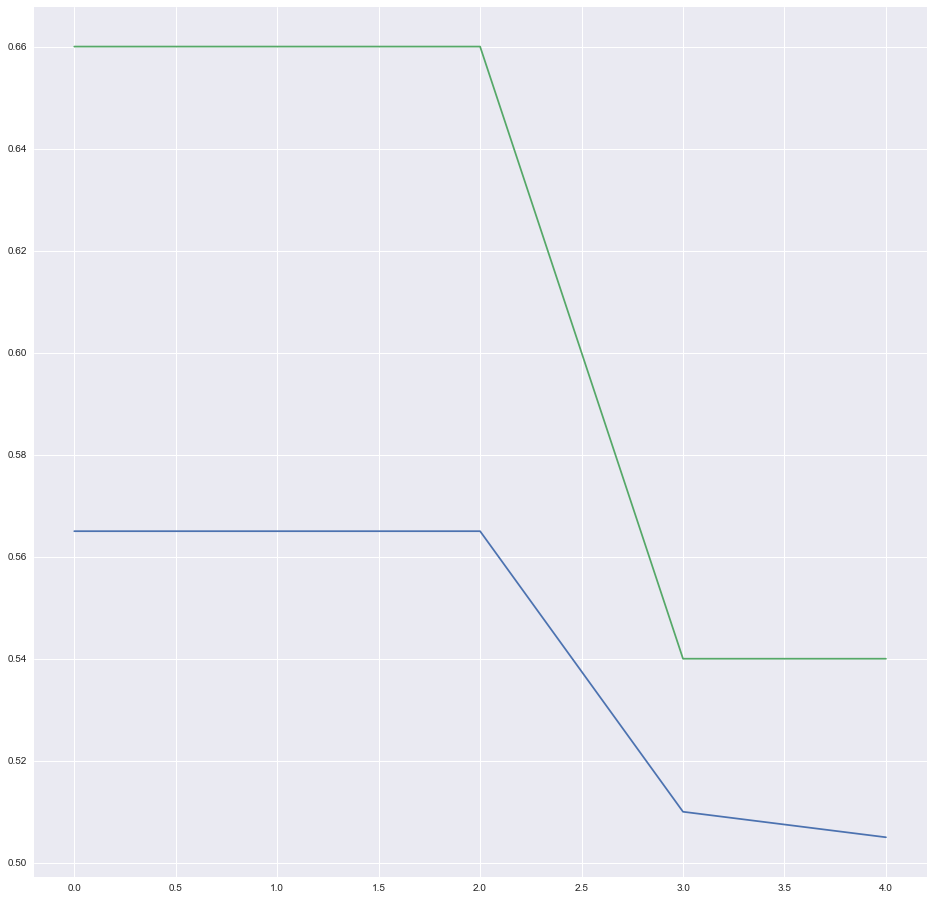

In [11]:
plt.plot(meanErrorByC(X_train_val, Y_train_val, X_val, Y_val, [10, 100, 1e3, 1e6, 1e10]))

We can see than neither the train or test validation provide a good solution.
For the train set we can see that the higher the C the less accuracy we have, this will be due to the fact that a margins are greater and more support vectors are found.
But the error reducing is appreciatted in the test sample with higher C values.

** Question 3 (5 points)** Train a SVM with a RBF kernel with bandwith $\gamma$. Plot the decision boundary and the $\pm 1$-distance to boundary contour levels. 

Use different values of $(C,\gamma)$ and analyze the evolution of the number of support vectors as you vary these quantities. For instance, fix $\gamma=1$ and vary $C$ and the other way around. Explain the results! Plotting the decision boundary and support vectors will help you to understand what's going on.

Note: check [here](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) to see how to vary $\gamma$.

For different values of $\gamma$, compute and plot the classification error rate for both training and validation sets as a function of $C$.


In [12]:
#Your code here
clf1 = SVC(kernel='rbf',C=1e6, gamma=1).fit(X_train_val, Y_train_val)

C:\Users\borja\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


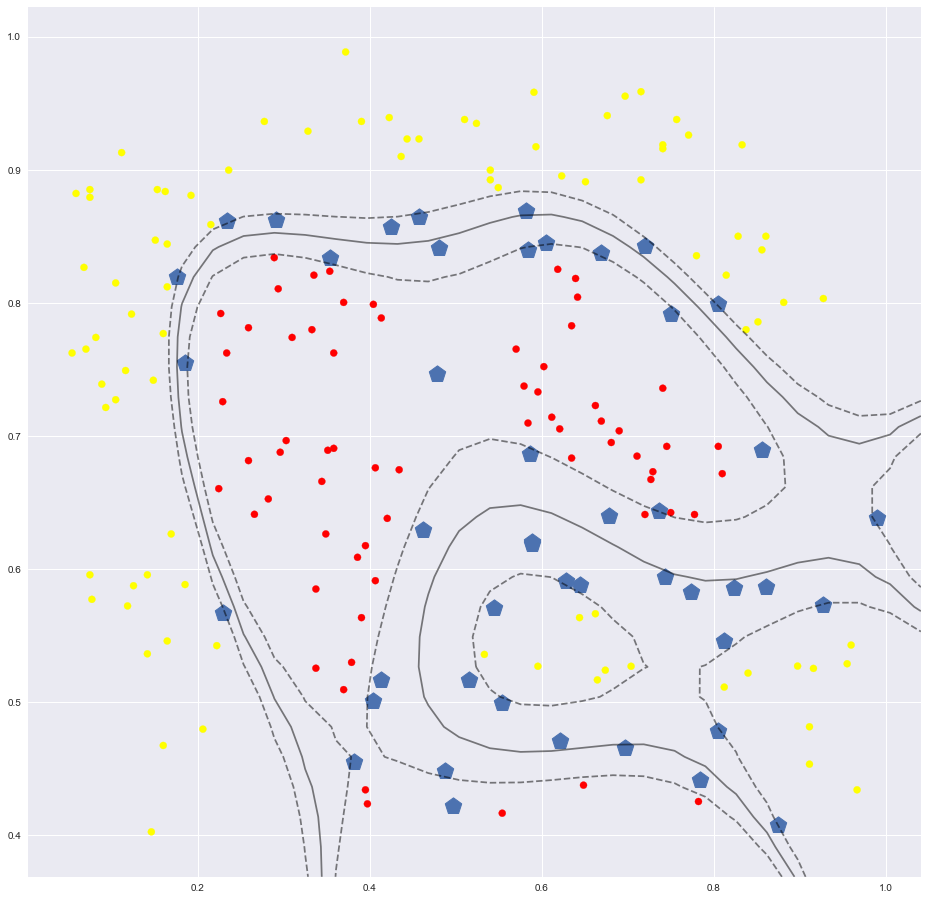

In [13]:
plt.scatter(X_train_val[:, 0], X_train_val[:, 1], c=np.reshape(Y_train_val, [200,]), s=50, cmap='autumn')
plot_svc_decision_function(clf1)

In [14]:
def checkSupportVectorsForCvsGamma(X, Y, gammaArray, cArray):
    f, axes = plt.subplots(len(cArray), len(gammaArray))
    supportVectors = np.zeros([len(cArray), len(gammaArray)])
    for indexi, cVal in enumerate(cArray):
        for indexj, gammaVal in enumerate(gammaArray):
            model = SVC(kernel='rbf', C=cVal, gamma=gammaVal).fit(X, np.ravel(Y))
            supportVectors[indexi, indexj] = len(model.support_vectors_)
            axes[indexi, indexj].scatter(X[:, 0], X[:, 1], c=np.reshape(Y_train_val, [200,]), s=50, cmap='autumn')
            plot_svc_decision_function(model,ax=axes[indexi, indexj], plot_support=True)
    return supportVectors

[[ 127.  104.   89.   82.]
 [ 100.   90.   58.   51.]
 [  91.   66.   35.   30.]
 [  46.   21.   21.   22.]
 [  26.   20.   21.   22.]]


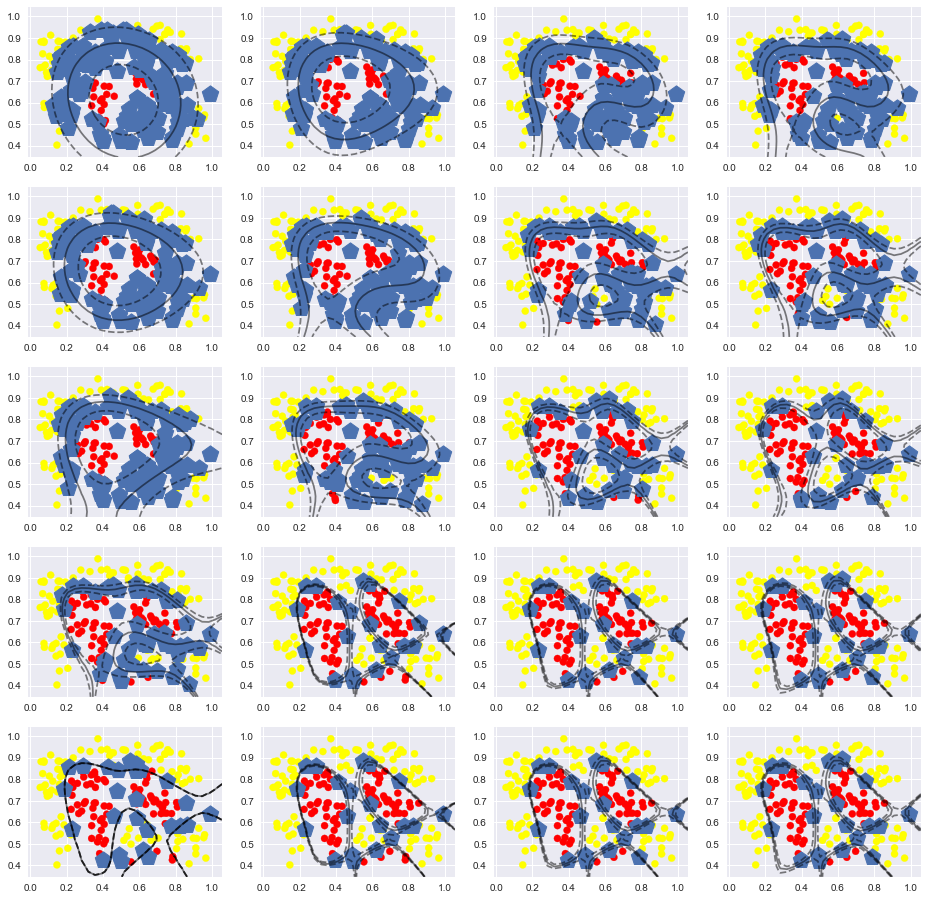

In [15]:
print(checkSupportVectorsForCvsGamma(X_train_val, Y_train_val, [1,3,7,9], [10, 100, 1e3, 1e6, 1e10]))

plt.rcParams["figure.figsize"] = [10,10]

We can again appreciatte that the higher C the less support Vector are found for every gamma. Also since gamma changes the form of the fitting function changes to fit in various ways.

In [16]:
def meanErrorByGamma(X, Y, Xval, Yval, gammaArray, fixedCValue):
    accuracy = np.zeros([len(gammaArray), 2])
    for index, gammaValue in enumerate(gammaArray):
        model = SVC(kernel='rbf', C=fixedCValue, gamma=gammaValue)
        model.fit(X, np.ravel(Y))
        accuracy[index,0] = accuracy_score(Y, model.predict(X))
        accuracy[index,1] = accuracy_score(Yval, model.predict(X_val))
    return accuracy

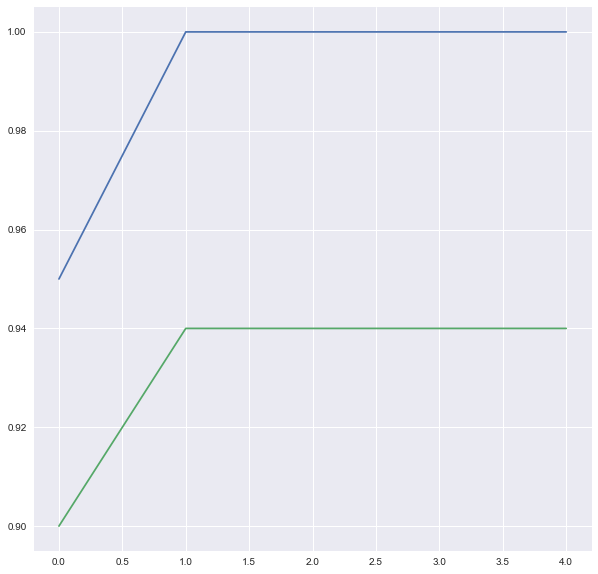

In [17]:
plt.plot(meanErrorByGamma(X_train_val, Y_train_val, X_val, Y_val, [1,3,6,8,10], 1e8))